# Modelos Lineales, Optimización

Se implementará un clasificador lineal y se entrenará usando gradiente descendente estocástico, con modificaciones y numpy.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Clasificación bidimensional

Para hacer las cosas más intuitivas, vamos a resolver un preblema de clasificación 2D con datos sintéticos.

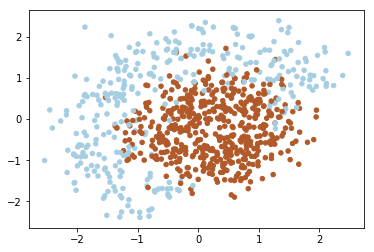

In [2]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show();

# Tarea

## Características

Es evidente que los datos que se muestran arriba no son linealmente separables. Por ello, debemos añadir características, o usar modelos no lineales. Hay que notar que la línea de decisión entre las dos clases tiene forma circular, por lo que se pueden añadir características cuadráticas para convertir el problema en linealmente separable. La idea subyacente a esto se muestra debajo:

![](kernel.png)

In [3]:
def expandir(X):
    """
    Añade características cuadráticas. 
    Esta expansión permite al modelo lineal realizar separaciones no lineales.
    
    Para cada muestra (fila de una matriz), computa una fila expandida:
    [característica0, característica1, fcaracterística0^2,
     característica1^2, característica0*característica1, 1]
    
    :parámetro X: matriz de características, dimensiones [n_muestras,2]
    :retorna: características expandidas de dimensiones [n_muestras,6]
    """
    
    X_expandida = np.zeros((X.shape[0], 6))
    
    X_expandida[:, 5] = 1
    X_expandida[:, 4] = X[:, 0] * X[:, 1]
    X_expandida[:, 3] = X[:, 1] ** 2
    X_expandida[:, 2] = X[:, 0] ** 2
    X_expandida[:, 1] = X[:, 1]
    X_expandida[:, 0] = X[:, 0]
    
    return X_expandida

In [4]:
X_expandida = expandir(X)

Aquí se hacen algunos testeos de la implementación de la función `expandir`.

In [6]:
# test simple en números aleatorios

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# llama a la función expandir
dummy_expandida = expandir(dummy_X)

# lo que debería devolver      :   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expandida_res = np.array([[ 0.   ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

# testeo
assert isinstance(dummy_expandida, np.ndarray), 'por favor, asegúrate de retornar una array de numpy'
assert dummy_expandida.shape==dummy_expandida_res.shape,'por favor, asegúrate de que la dimensión es correcta'
assert np.allclose(dummy_expandida, dummy_expandida_res,1e-3), 'Algo es erróneo en las características'

print('¡Correcto!')


¡Correcto!


## Regresión Logística

Para clasificar objetos se obtendrá la probabilidad de que el objeto pertenezca a la clase '1'. Para predecir la probabilidad se usará la salida del modelo lineal y de la función logística:


$$ a(x; w) = \langle w, x \rangle $$

$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [7]:
def probabilidad(X, w):
    """
    Dadas una características de entrada y unos pesos
    retorna las probabilidades predichas de y==1 dado x, P(y=1|x), mira la descripción arriba
    
    No olvides usar la función expandir(X), donde sea necesario, en ésta o siguientes funciones.
    
    :parámetro X: matriz de características X de dimensiones [n_muestras,6] (expandida)
    :parámetro w: vector de pesos de dimensión 6 para cada una de las características expandidas
    :retorna: un array de las probabilidades predichas en el intervalo [0,1].
    """
    
    return 1 / (1 + np.exp(-np.dot(X, w)))

In [8]:
dummy_pesos = np.linspace(-1, 1, 6)
parte1_res = probabilidad(X_expandida[:1, :], dummy_pesos)[0]
print(parte1_res)

0.3803998509843769


En la regresión logística, el parámetro $w$ óptimo se encuentra minimizando la entropía cruzada:

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$



In [9]:
def calcula_perdida(X, y, w):
    """
    Dada una matriz de características X [n_muestras,6], un vector objetivo (y) de 1s o 0s,
    y un vector de pesos w [6], calcula la función escalar de pérdida usando la fórmula
    escrita arriba.
    """

    prob = probabilidad(X, w)
    a = (1 - y) * np.log(1 - prob)
    b = y * np.log(prob)
    return  - np.mean(a + b)

In [10]:
parte2_res = calcula_perdida(X_expandida, y, dummy_pesos)
print(parte2_res)

1.0185634030782518


Dado que el modelo entrena con el gradiente descente, debemos calcular el gradiente.

Para ser más específico, necesitamos derivar la función de pérdida con respecto 
a cada uno de los pesos (6 en total).

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \left[ ({log P(y_i = 1 \, | \, x_i,w) - y_i})  \cdot x_j \right]$$


In [13]:
def calcula_grad(X, y, w):
    """
    Dada una matriz de características X [n_muestras,6], un vector objetivo (y) de 1s o 0s,
    y un vector de pesos w [6], calcula el vector de derivadas de L para cada peso.
    """
        
    return np.dot(X.T, probabilidad(X, w) - y) / X.shape[0]

In [14]:
parte3_res = np.linalg.norm(calcula_grad(X_expandida, y, dummy_pesos))
print (parte3_res)

0.6401687302118625


Ahora se realiza una función auxiliar para visualizar las predicciones:

In [23]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualiza(X, y, w, historia):
    
    """dibuja la predicción del clasificador con matplotlib magic"""
    
    Z = probabilidad(expandir(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(historia)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show();

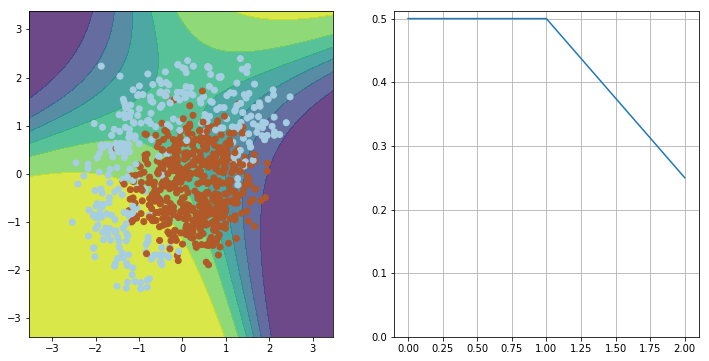

In [24]:
visualiza(X, y, dummy_pesos, [0.5, 0.5, 0.25])

## Entrenamiento
En ésta sección se usarán las funciones que se escrito para entrenar el clasificador usando gradiente descente estocástico.

You can try change hyperparameters like batch size, learning rate and so on to find the best one, but use our hyperparameters when fill answers.

## Mini-batch SGD

Stochastic gradient descent just takes a random example on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



In [ ]:
# please use np.random.seed(42), eta=0.1, n_iter=100 and batch_size=4 for deterministic results

np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>

    w =  w - eta * compute_grad(X_expanded, y, w)

visualize(X, y, w, loss)
plt.clf();

In [ ]:
# use output of this cell to fill answer field 

ans_part4 = compute_loss(X_expanded, y, w)

## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)


In [ ]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

update = 0

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    
    update =  update * alpha + eta * compute_grad(X_expanded, y, w)
    
    w =  w - update

visualize(X, y, w, loss)
plt.clf()

In [ ]:
# use output of this cell to fill answer field 

ans_part5 = compute_loss(X_expanded, y, w)

## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

In [ ]:
# please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
g2 = None
eps = 1e-8

G = 0

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # TODO:<your code here>
    
    G = alpha * G + (1 - alpha) * compute_grad(X_expanded, y, w) ** 2
    
    w = w - eta / np.sqrt(G + eps) * compute_grad(X_expanded, y, w)

visualize(X, y, w, loss)
plt.clf()

In [ ]:
# use output of this cell to fill answer field 
ans_part6 = compute_loss(X_expanded, y, w)